<h1>Process & the ML Agenda</h1>

Process info from Monmouth University 2020 national poll

- courtesy of your mom

In [150]:
import os 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split

<h2>Rename Columns</h2>

In [151]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")

In [152]:
propensity = pd.read_csv("../data/propensity_by_group_2500.csv", index_col=0)
propensity

,age_recoded,race_recoded,male,education_recoded,mrp_subgroup_estimate,mrp_subgroup_estimate_se
1,1,1,False,1,0.530773,0.065225
2,1,1,False,3,0.527561,0.153467
3,1,1,True,1,0.530773,0.065225
4,1,1,True,3,0.527561,0.153467
5,1,2,False,1,0.085151,0.036493
6,1,2,False,3,0.100076,0.086448
7,1,2,True,1,0.085151,0.036493
8,1,2,True,3,0.100076,0.086448
9,1,3,False,1,0.214099,0.093922
10,1,3,False,3,0.224468,0.148120


In [153]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6A', 'Q6B', 'Q6C',
       'Q6D', 'Q6E', 'Q6F', 'Q7', 'Q8', 'Q9', 'Q9A.1', 'Q9A.2', 'Q9A.3',
       'Q10A', 'Q10B', 'Q10C', 'Q10D', 'Q10E', 'Q10F', 'Q10G', 'QD1', 'Q11',
       'Q12', 'Q12B', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'QD2',
       'QD2A', 'QD3', 'QD4', 'QD5', 'QD5A', 'QD6', 'QD7', 'QD8', 'QD9', 'QD10',
       'QD11', 'FINALWGT'],
      dtype='object')

In [154]:
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})

# Big Function to encode columns

In [539]:
def recodeCols(df):

    cols = df.columns
    # vote choice
    if '12_2' not in cols:
        # for march 2020 data
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))
    else:
        # for june 2020 data
        df['vote_choice'] = df.apply(lambda s: np.where(pd.isnull(s['12_1']), s['12_2'], s['12_1']), axis = 1)
      
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))
    # party recode
    df['party_recoded'] = df.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
    df['party_recoded'] = df['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

    # age recode
    df['age_recoded'] = df.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

    df['age_recoded'] = df['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, np.where(s >= 35 and s <= 54, 2.0, 3.0)))   

    # approval ratings 
    df['approve_trump'] = df['approve_trump'] == 1
    df['approve_biden'] = df['approve_biden'] == 1 

    # race, overwrite if hispanic/latino
    df['latino'] = df['latino'] == 1

    def recode_race(s):
        if s['latino'] == 1 or s['race'] == 4: 
            return 4
        elif s['race'] != 5 and s['race'] != 9:
            return s['race']
        else:
            return 9
    df['race_recoded'] = df.apply(recode_race, axis = 1)

    # gender => male = True, female = False
    df['male'] = df['gender'] == 1

    # registered to vote

    df['registered_vote'] = df['registered_vote'] == 1


    # True if they think Trump is focused on important issues, False otherwise
    if 'focused_imp_issues' in cols:
        df['focused_imp_issues'] = df['focused_imp_issues'] == 1

    # combine some of the similar household concern categories 
    if 'top_household_concern' in cols:
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

    # turn into 1 = no college, 3 = college
    def recode_education(s):
        if s <= 3:
            return 1
        else:
            return 3
    df['education_recoded'] = df['education'].apply(recode_education)
    # combine into liberal, conservative, moderate, or other
    def recode_political_leaning(s):
        if s <= 2:
            return 1
        elif s == 4 or s == 9:
            return 2
        elif s == 3:
            return 3
        else:
            return 4
    df['political_leaning'] = df['political_leaning'].apply(recode_political_leaning)

    # Do you feel optimistic or pessimistic about the 2020 presidential election? 1 or 2 = optimistic of some sort, else pessimistic of some sort
    df['optimistic'] = df['optimistic'] <= 2

    # confidence in trump stamina to be president, under 2 is confident, over 2 is not confident
    if 'trump_stamina' in cols:
        df['trump_stamina'] = df['trump_stamina'] <= 2
    # confidence in biden stamina to be president, under 2 is confident, over 2 is not confident
    if 'biden_stamina' in cols:
        df['biden_stamina'] = df['biden_stamina'] <= 2
    ### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
    def recode_region(s):
        new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
        midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
        south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
        west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
        
        if s in new_england:
            return 1
        elif s in midwest:
            return 2 
        elif s in south:
            return 3
        elif s in west:
            return 4
        
    df['region'] = df['state'].apply(recode_region)

    # merge propensities
    df['age_recoded'] = df['age_recoded'].astype(int)
    df_result = pd.merge(df, propensity, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                        how='left')

    # Renaming the merged column for clarity
    df['propensity'] = df_result['mrp_subgroup_estimate']
    df = df.dropna(subset = ['vote_choice_recoded'], how = 'all')

    return df

In [155]:
nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])

In [156]:
nat_2020['vote_choice'].value_counts()

vote_choice
2.0    358
1.0    320
8.0     39
6.0     21
9.0     12
7.0      3
Name: count, dtype: int64

In [157]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'top_household_concern', 'registered_vote',
       'likely_to_vote', 'vote_choice', 'vote_choice_undecided',
       'approve_trump', 'approve_biden', 'optimistic', 'elec_enthusiasm',
       'economic_situation', 'focused_imp_issues', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT'],
      dtype='object')

<h2>Recode Variables</h2>

<h3>Vote Choice</h3>

In [158]:
nat_2020['vote_choice_recoded'] = nat_2020.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat_2020['vote_choice_recoded'] = nat_2020['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Party Leaning</h3>

In [159]:
nat_2020['party_recoded'] = nat_2020.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
nat_2020['party_recoded'] = nat_2020['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

<h3>Age</h3>

Convert so they're all in bins

In [160]:
nat_2020['age_recoded'] = nat_2020.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

nat_2020['age_recoded'] = nat_2020['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, 
                                                        np.where(s >= 35 and s <= 54, 2.0, 3.0)))

<h3>Approval Ratings</h3>

In [161]:
nat_2020['approve_trump'] = nat_2020['approve_trump'] == 1
nat_2020['approve_biden'] = nat_2020['approve_biden'] == 1

<h3>Race</h3>

Overwrite if hispanic/latino

In [162]:
nat_2020['latino'] = nat_2020['latino'] == 1

In [163]:
def recode_race(s):
    if s['latino'] == 1 or s['race'] == 4: 
        return 4
    elif s['race'] != 5 and s['race'] != 9:
        return s['race']
    else:
        return 9

In [164]:
nat_2020['race_recoded'] = nat_2020.apply(recode_race, axis = 1)

<h3>Gender</h3>

In [165]:
nat_2020['male'] = nat_2020['gender'] == 1

In [166]:
# nat_2020.to_csv("../data/nat_2020_cleaned_no_dummies.csv", index = False)

In [167]:
nat_2020['registered_vote'].value_counts()

registered_vote
1    754
2     94
9      3
Name: count, dtype: int64

In [168]:
nat_2020['focused_imp_issues'].value_counts()

focused_imp_issues
2    399
1    394
9     58
Name: count, dtype: int64

In [169]:
nat_2020['age_recoded'].value_counts()

age_recoded
3.0    357
2.0    304
1.0    190
Name: count, dtype: int64

In [170]:
nat_2020['economic_situation'].value_counts()

economic_situation
2    548
1    202
3     93
9      8
Name: count, dtype: int64

<h3>Registered to Vote</h3>

In [171]:
# True if they're registered to vote, false otherwise
nat_2020['registered_vote'] = nat_2020['registered_vote'] == 1

<h3>Focused on Important Issues</h3>

In [172]:
# True if they think Trump is focused on important issues, False otherwise
nat_2020['focused_imp_issues'] = nat_2020['focused_imp_issues'] == 1

In [173]:
nat_2020['focused_imp_issues'].value_counts()

focused_imp_issues
False    457
True     394
Name: count, dtype: int64

<h3>Combine Concerns</h3>

In [174]:
# combine some of the similar household concern categories 
nat_2020['top_household_concern'] = nat_2020['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
nat_2020['top_household_concern'] = nat_2020['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

<h3>Education</h3>

In [175]:
# turn into no high school, some college or vocational, college or others 
def recode_education(s):
    if s <= 3:
        return 1
    # elif s > 4 and s <=6:
    #     return 2
    else:
        return 3
    # else:
    #     return 9

In [176]:
nat_2020['education_recoded'] = nat_2020['education'].apply(recode_education)

<h3>Political Leaning</h3>

In [177]:
# combine into liberal, conservative, moderate, or other
def recode_political_leaning(s):
    if s <= 2:
        return 1
    elif s == 4 or s == 9:
        return 2
    elif s == 3:
        return 3
    else:
        return 4

In [178]:
nat_2020['political_leaning'] = nat_2020['political_leaning'].apply(recode_political_leaning)

<h3>Optimistic</h3>

In [179]:
# true if optimistic about website, false otherwise
nat_2020['optimistic'] = nat_2020['optimistic'] <= 2

<h3>Region</h3>

In [180]:
### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
def recode_region(s):
    new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
    midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
    south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
    west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
    
    if s in new_england:
        return 1
    elif s in midwest:
        return 2 
    elif s in south:
        return 3
    elif s in west:
        return 4
    
    

In [181]:
nat_2020['region'] = nat_2020['state'].apply(recode_region)

### merge propensity to this

In [182]:
# prop_avg_values = propensity.groupby(['male', 'race_recoded', 'education_recoded', 'age_recoded'])['mean'].max().reset_index()
# prop_avg_values
# make age recoded into int
nat_2020['age_recoded'] = nat_2020['age_recoded'].astype(int)
df_result = pd.merge(nat_2020, propensity, 
                     on=['male', 'race_recoded', 'education_recoded', 'age_recoded'], 
                     how='left')

# Renaming the merged column for clarity
nat_2020['propensity'] = df_result['mrp_subgroup_estimate']
nat_2020

,RESPID,PHTYPE,top_household_concern,registered_vote,likely_to_vote,vote_choice,vote_choice_undecided,approve_trump,approve_biden,optimistic,...,state,FINALWGT,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,11,2,20.0,True,1.0,9.0,9.0,False,False,True,...,24.0,0.879980,3.0,1.0,2,1,True,3,3.0,0.670994
1,14,2,29.0,True,1.0,1.0,NaN,True,False,True,...,34.0,1.089499,1.0,3.0,1,1,True,3,1.0,0.527561
2,19,2,28.0,True,1.0,1.0,NaN,True,False,True,...,37.0,0.520273,1.0,1.0,3,1,True,3,3.0,0.662109
3,30,2,20.0,True,1.0,2.0,NaN,False,True,True,...,37.0,0.573839,2.0,2.0,3,1,False,3,3.0,0.662109
4,43,2,20.0,True,1.0,8.0,1.0,False,True,False,...,13.0,0.972234,1.0,1.0,2,9,False,3,3.0,0.471235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,3746,1,10.0,True,1.0,2.0,NaN,False,False,False,...,26.0,0.469501,2.0,3.0,2,1,True,3,2.0,0.670994
847,3752,1,20.0,False,NaN,NaN,NaN,False,False,True,...,24.0,1.207679,NaN,2.0,1,1,False,3,3.0,0.527561
848,3754,2,30.0,True,1.0,8.0,3.0,True,True,True,...,12.0,0.906539,3.0,2.0,3,1,False,3,3.0,0.662109
849,3762,1,20.0,True,3.0,2.0,NaN,False,True,True,...,22.0,0.665262,2.0,2.0,2,2,False,3,3.0,0.166517


## Test Big function

In [437]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])
nat_2020 = recodeCols(nat_2020)

In [508]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")

nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8A',
       'Q8B', 'Q8C', 'Q9', 'Q10', 'Q10A', 'Q10B', 'QD1', 'Q11', 'Q12_1',
       'Q12_2', 'Q12A', 'Q12B', 'Q13A', 'Q13B', 'Q14', 'Q14A', 'Q15', 'Q16',
       'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26',
       'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q35A',
       'Q35B', 'QD2', 'QD2A', 'QD2B', 'QD3', 'QD4', 'QD5', 'QD5A', 'QD6',
       'QD7', 'QD8', 'QD9', 'QD10', 'QD11', 'FINALWGT'],
      dtype='object')

In [522]:
nat_2020_june[['Q12_1',
       'Q12_2']]
#merge the two vote choice columns
nat_2020_june['vote_choice'] = nat_2020_june.apply(lambda s: np.where(pd.isnull(s['Q12_1']), s['Q12_2'], s['Q12_1']), axis = 1)
# drop row if 'Q12_1', 'Q12_2', 'Q12A', 'Q12B' all are null

nat_2020_june = nat_2020_june.dropna(subset = ['Q12_1', 'Q12_2', 'Q12A', 'Q12B'], how = 'all')

nat_2020_june['vote_choice_recoded'] = nat_2020_june.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
nat_2020_june['vote_choice_recoded'] = nat_2020_june['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))

(732, 67)
(732, 67)


In [523]:
nat_2020_june['vote_choice_recoded'].value_counts()

vote_choice_recoded
2.0    405
1.0    289
3.0     38
Name: count, dtype: int64

In [520]:
nat_2020_june[['Q12_1',
       'Q12_2', 'Q12A', 'Q12B', 'vote_choice', 'vote_choice_recoded']]

,Q12_1,Q12_2,Q12A,Q12B,vote_choice,vote_choice_recoded
0,2.0,NaN,1.0,NaN,2.0,2.0
1,NaN,2.0,1.0,NaN,2.0,2.0
2,2.0,NaN,1.0,NaN,2.0,2.0
5,NaN,2.0,1.0,NaN,2.0,2.0
6,NaN,2.0,2.0,NaN,2.0,2.0
...,...,...,...,...,...,...
862,6.0,NaN,2.0,1.0,6.0,1.0
863,NaN,1.0,1.0,NaN,1.0,1.0
864,1.0,NaN,1.0,NaN,1.0,1.0
865,2.0,NaN,1.0,NaN,2.0,2.0


In [545]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")
nat_2020_june = nat_2020_june.rename(columns = {
        # 'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12_1': '12_1',
        'Q12_2': '12_2',
        'Q12B': 'vote_choice_undecided', 
        'Q15': 'approve_trump',
        'Q16': 'approve_biden',
        'Q19': 'optimistic',
        'Q21': 'elec_enthusiasm',
        'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        'Q17': 'trump_stamina',
        'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_june = nat_2020_june.drop(columns = [c for c in nat_2020_june.columns if 'Q' in c])
nat_2020_june = recodeCols(nat_2020_june)
nat_2020_june.drop(columns=['12_1', '12_2', 'vote_choice', 'vote_choice_undecided'], inplace = True)

In [546]:
nat_2020_june.columns

Index(['RESPID', 'PHTYPE', 'economic_situation', 'registered_vote',
       'likely_to_vote', 'approve_trump', 'approve_biden', 'trump_stamina',
       'biden_stamina', 'optimistic', 'elec_enthusiasm', 'party',
       'party_unaffiliated', 'political_leaning', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT',
       'vote_choice_recoded', 'party_recoded', 'age_recoded', 'race_recoded',
       'male', 'education_recoded', 'region', 'propensity'],
      dtype='object')

<h2>Add Dummy Variables</h2>

In [549]:
# categoricals = ['top_household_concern', 'registered_vote', 'region',
#                 'likely_to_vote', 'vote_choice', 'vote_choice_undecided', 
#                 'elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded', 'economic_situation', 'education_recoded']

categoricals = ['top_household_concern', 'registered_vote', 'region','economic_situation','likely_to_vote', 'vote_choice', 'vote_choice_undecided', 'education_recoded','elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded']
june_categoricals = ['registered_vote', 'region','economic_situation','likely_to_vote',  'education_recoded','elec_enthusiasm', 'political_leaning','race_recoded', 'party_recoded', 'age_recoded']

In [573]:
def dummyGrabber(df, cats):
    for category in cats:
        df[category] = df[category].astype('category')
    dummies = pd.get_dummies(df[cats])
    df = df[[c for c in df.columns if c not in cats]]
        
    df = pd.concat([df, dummies], axis = 1)
    
    return df

In [440]:
for category in categoricals:
    nat_2020[category] = nat_2020[category].astype('category')


# dummies = pd.get_dummies(nat_2020[categoricals], drop_first=True)
dummies = pd.get_dummies(nat_2020[categoricals])

In [441]:
dummies


,top_household_concern_1.0,top_household_concern_2.0,top_household_concern_3.0,top_household_concern_4.0,top_household_concern_5.0,top_household_concern_6.0,top_household_concern_8.0,top_household_concern_9.0,top_household_concern_10.0,top_household_concern_12.0,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False
847,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
848,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
849,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,True,False


In [443]:
nat_2020 = nat_2020[[c for c in nat_2020.columns if c not in categoricals]]

In [444]:
nat_2020 = pd.concat([nat_2020, dummies], axis = 1)

In [445]:
nat_2020 = nat_2020[(nat_2020['vote_choice_recoded'] != 3.0) | 
                    (nat_2020['vote_choice_recoded'] != 7.0) |
                    (pd.isnull(nat_2020['vote_choice_recoded']) == False)]






In [446]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'party', 'party_unaffiliated', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT',
       'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_18.0',
       'top_household_concern_19.0', 'top_household_concern_20.0',
       'top_household_concern_28.0', 'top_household_concern_29.0',
       'top_household_concern_30.0', 'registered_vote_False',
  

<h2>Train Test Split</h2>

In [447]:
X_train, X_test = train_test_split(nat_2020, test_size = 0.2, random_state = 42)

In [448]:
# X_train.to_csv('../data/nat_2020_train.csv', index = False)
# X_test.to_csv('../data/nat_2020_test.csv', index = False)

In [449]:
X_train.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'party', 'party_unaffiliated', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT',
       'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_18.0',
       'top_household_concern_19.0', 'top_household_concern_20.0',
       'top_household_concern_28.0', 'top_household_concern_29.0',
       'top_household_concern_30.0', 'registered_vote_False',
  

In [450]:
nat_2020['vote_choice_recoded']
# 1 is trump, 2 is biden, 3 is other/undecided/none
nat_2020['vote_choice_recoded'].value_counts()

vote_choice_recoded
2.0    381
1.0    334
3.0     38
Name: count, dtype: int64

In [451]:
nat_2020.columns

Index(['RESPID', 'PHTYPE', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'party', 'party_unaffiliated', 'education', 'age',
       'age_bin', 'latino', 'race', 'gender', 'state', 'FINALWGT',
       'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_18.0',
       'top_household_concern_19.0', 'top_household_concern_20.0',
       'top_household_concern_28.0', 'top_household_concern_29.0',
       'top_household_concern_30.0', 'registered_vote_False',
  

In [574]:
june_dummies = dummyGrabber(nat_2020_june, june_categoricals)

In [575]:
# june_dummies.columns
nat_2020_june_clean = june_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state'])
nat_2020_june_clean

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,FINALWGT,vote_choice_recoded,male,propensity,registered_vote_True,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,True,False,True,False,0.649035,2.0,False,0.161233,True,...,True,False,False,False,False,True,False,False,False,True
1,False,False,False,True,True,0.585878,2.0,True,0.662109,True,...,False,False,False,False,False,True,False,False,False,True
2,False,True,False,True,True,0.943746,2.0,False,0.166517,True,...,True,False,False,False,False,True,False,False,True,False
5,False,False,False,True,False,1.355759,2.0,False,0.684399,True,...,False,False,False,False,False,True,False,False,True,False
6,False,False,False,True,True,0.524317,2.0,True,0.670994,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,False,False,True,False,True,1.084173,1.0,True,0.678370,True,...,False,False,False,False,False,False,True,False,False,True
863,True,False,True,False,True,2.519819,1.0,True,0.337659,True,...,False,True,False,False,True,False,False,False,True,False
864,True,False,True,False,True,0.864748,1.0,False,0.670994,True,...,False,False,False,False,True,False,False,False,True,False
865,False,False,False,True,True,1.029771,2.0,False,0.662109,True,...,False,False,False,False,False,True,False,False,False,True


In [624]:
nat_2020_june

,RESPID,PHTYPE,economic_situation,registered_vote,likely_to_vote,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,...,state,FINALWGT,vote_choice_recoded,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity
0,4,2,1,True,1.0,False,True,False,True,False,...,37,0.649035,2.0,2.0,3,2,False,3,3,0.161233
1,5,2,2,True,1.0,False,False,False,True,True,...,36,0.585878,2.0,2.0,3,1,True,3,1,0.662109
2,17,2,2,True,1.0,False,True,False,True,True,...,13,0.943746,2.0,2.0,2,2,False,3,3,0.166517
5,21,2,1,True,1.0,False,False,False,True,False,...,42,1.355759,2.0,2.0,2,1,False,1,1,0.684399
6,22,2,1,True,2.0,False,False,False,True,True,...,9,0.524317,2.0,1.0,2,1,True,3,1,0.670994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,20778,2,2,True,3.0,False,False,True,False,True,...,34,1.084173,1.0,3.0,3,1,True,1,1,0.678370
863,20786,1,2,True,1.0,True,False,True,False,True,...,53,2.519819,1.0,1.0,2,3,True,3,4,0.337659
864,20787,1,2,True,1.0,True,False,True,False,True,...,6,0.864748,1.0,1.0,2,1,False,3,4,0.670994
865,20789,1,2,True,1.0,False,False,False,True,True,...,6,1.029771,2.0,2.0,3,1,False,3,4,0.662109


## drop columns that made voter choice recoded column

In [454]:
nat_2020_clean = nat_2020.drop(columns=[
       'vote_choice_1.0','vote_choice_2.0', 'vote_choice_6.0',
       'vote_choice_7.0', 'vote_choice_8.0', 'vote_choice_9.0', 'vote_choice_undecided_1.0',
       'vote_choice_undecided_2.0', 'vote_choice_undecided_3.0',
       'vote_choice_undecided_9.0',
       'RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state'])

nat_2020_clean.columns

# keep or or drop FINALWGT?
# use state? income? education? -> not in data rn, keep in mind for future


# nat_2020_clean.to_csv('yeet.csv', index = False)

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'FINALWGT', 'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_18.0',
       'top_household_concern_19.0', 'top_household_concern_20.0',
       'top_household_concern_28.0', 'top_household_concern_29.0',
       'top_household_concern_30.0', 'registered_vote_False',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_situati

In [455]:
# pull up column focused_imp_issues_2

nat_2020_clean.columns

Index(['approve_trump', 'approve_biden', 'optimistic', 'focused_imp_issues',
       'FINALWGT', 'vote_choice_recoded', 'male', 'propensity',
       'top_household_concern_1.0', 'top_household_concern_2.0',
       'top_household_concern_3.0', 'top_household_concern_4.0',
       'top_household_concern_5.0', 'top_household_concern_6.0',
       'top_household_concern_8.0', 'top_household_concern_9.0',
       'top_household_concern_10.0', 'top_household_concern_12.0',
       'top_household_concern_13.0', 'top_household_concern_14.0',
       'top_household_concern_15.0', 'top_household_concern_16.0',
       'top_household_concern_17.0', 'top_household_concern_18.0',
       'top_household_concern_19.0', 'top_household_concern_20.0',
       'top_household_concern_28.0', 'top_household_concern_29.0',
       'top_household_concern_30.0', 'registered_vote_False',
       'registered_vote_True', 'region_1.0', 'region_2.0', 'region_3.0',
       'region_4.0', 'economic_situation_1', 'economic_situati

In [456]:
# get propensity scores, use those as a column in the data, then train on data + that then 
nat_2020.loc[776].to_dict()

{'RESPID': 3484,
 'PHTYPE': 1,
 'approve_trump': False,
 'approve_biden': False,
 'optimistic': False,
 'focused_imp_issues': False,
 'party': 2,
 'party_unaffiliated': nan,
 'education': 7,
 'age': 65,
 'age_bin': nan,
 'latino': False,
 'race': 2,
 'gender': 2,
 'state': 13.0,
 'FINALWGT': 0.772958285,
 'vote_choice_recoded': 2.0,
 'male': False,
 'propensity': 0.161233254175788,
 'top_household_concern_1.0': False,
 'top_household_concern_2.0': True,
 'top_household_concern_3.0': False,
 'top_household_concern_4.0': False,
 'top_household_concern_5.0': False,
 'top_household_concern_6.0': False,
 'top_household_concern_8.0': False,
 'top_household_concern_9.0': False,
 'top_household_concern_10.0': False,
 'top_household_concern_12.0': False,
 'top_household_concern_13.0': False,
 'top_household_concern_14.0': False,
 'top_household_concern_15.0': False,
 'top_household_concern_16.0': False,
 'top_household_concern_17.0': False,
 'top_household_concern_18.0': False,
 'top_household_

In [457]:
nat_2020_clean['vote_choice_recoded'].value_counts()
# if vote choice recorded is 7, make the value 3
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 7, 3, s))
nat_2020_clean['vote_choice_recoded'].isna().sum()

98

In [458]:
# (nat_2020_clean['vote_choice_recoded'] == 3.0).sum() sum of 3.0 answers is 38
# drop vote choice 3.0
nat_2020_clean = nat_2020_clean[nat_2020_clean['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_clean = nat_2020_clean.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].astype(int)
nat_2020_clean['vote_choice_recoded'] = nat_2020_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

In [576]:
nat_2020_june_clean = nat_2020_june_clean[nat_2020_june_clean['vote_choice_recoded'] != 3.0]
# change trump to be 1 and biden to be 0
# biden originally encoded as 2 and trump as 1. 
# drop if vote choice recorded is null
nat_2020_june_clean = nat_2020_june_clean.dropna(subset = ['vote_choice_recoded'])
# vote choice recoded to int
nat_2020_june_clean['vote_choice_recoded'] = nat_2020_june_clean['vote_choice_recoded'].astype(int)
nat_2020_june_clean['vote_choice_recoded'] = nat_2020_june_clean['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))

In [554]:
nat_2020_clean['vote_choice_recoded'].value_counts().sum()

694

In [460]:
nat_2020_clean2= nat_2020_clean.drop(columns=['FINALWGT', ])

In [606]:
nat_2020_june_clean2 = nat_2020_june_clean.drop(columns=['FINALWGT', ])

In [592]:
nat_2020_june_clean

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,FINALWGT,vote_choice_recoded,male,propensity,registered_vote_True,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,True,False,True,False,0.649035,0,False,0.161233,True,...,True,False,False,False,False,True,False,False,False,True
1,False,False,False,True,True,0.585878,0,True,0.662109,True,...,False,False,False,False,False,True,False,False,False,True
2,False,True,False,True,True,0.943746,0,False,0.166517,True,...,True,False,False,False,False,True,False,False,True,False
5,False,False,False,True,False,1.355759,0,False,0.684399,True,...,False,False,False,False,False,True,False,False,True,False
6,False,False,False,True,True,0.524317,0,True,0.670994,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,False,False,True,False,True,1.084173,1,True,0.678370,True,...,False,False,False,False,False,False,True,False,False,True
863,True,False,True,False,True,2.519819,1,True,0.337659,True,...,False,True,False,False,True,False,False,False,True,False
864,True,False,True,False,True,0.864748,1,False,0.670994,True,...,False,False,False,False,True,False,False,False,True,False
865,False,False,False,True,True,1.029771,0,False,0.662109,True,...,False,False,False,False,False,True,False,False,False,True


In [461]:
# nat_2020_clean2['focused_imp_issues']

In [607]:
nat_2020_june_clean2

,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,vote_choice_recoded,male,propensity,registered_vote_True,region_1,...,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,party_recoded_3.0,age_recoded_1,age_recoded_2,age_recoded_3
0,False,True,False,True,False,0,False,0.161233,True,False,...,True,False,False,False,False,True,False,False,False,True
1,False,False,False,True,True,0,True,0.662109,True,True,...,False,False,False,False,False,True,False,False,False,True
2,False,True,False,True,True,0,False,0.166517,True,False,...,True,False,False,False,False,True,False,False,True,False
5,False,False,False,True,False,0,False,0.684399,True,True,...,False,False,False,False,False,True,False,False,True,False
6,False,False,False,True,True,0,True,0.670994,True,True,...,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,False,False,True,False,True,1,True,0.678370,True,True,...,False,False,False,False,False,False,True,False,False,True
863,True,False,True,False,True,1,True,0.337659,True,False,...,False,True,False,False,True,False,False,False,True,False
864,True,False,True,False,True,1,False,0.670994,True,False,...,False,False,False,False,True,False,False,False,True,False
865,False,False,False,True,True,0,False,0.662109,True,False,...,False,False,False,False,False,True,False,False,False,True


In [727]:
X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded'])
y = nat_2020_june_clean2['vote_choice_recoded']
# X = nat_2020_clean2.drop(columns = ['vote_choice_recoded'])
# y = nat_2020_clean2['vote_choice_recoded']
# train test split
# TODO: consider stratifying by anything???? 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 13, stratify=X['male'])

In [728]:
y_test.value_counts()

vote_choice_recoded
0    160
1    118
Name: count, dtype: int64

In [729]:
y_train.value_counts()

vote_choice_recoded
0    245
1    171
Name: count, dtype: int64

In [730]:
import os
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

In [731]:
models = [
  

    ("Logistic Regression Classification", LogisticRegression(), {'C': [1, 2]}),
    # ("SVC", SVC(C = 10), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}),
    # ("Decision Tree Regression", DecisionTreeClassifier(), {'max_depth':[0,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'n_estimators': [100,150,200]}),
    ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'n_estimators': [100,150,200]}), 
    ("Gradient Boosting Classification", GradientBoostingClassifier(criterion='squared_error', n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification2", GradientBoostingClassifier(criterion='squared_error', n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'n_estimators': [100,150,200]}),
    ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'n_estimators': [100,150,200]}),
    # ('xgb', XGBClassifier(), {'n_estimators': [100,150,200]}),

    # ("K-Nearest Neighbors Classification", KNeighborsClassifier(), {'n_neighbors': [3,5]}),
    # ("Neural Network Classification", MLPClassifier(max_iter=1000)),  # Specify appropriate hyperparameters

    
]

In [732]:
for model in models:
  
    name = model[0]
    print(model[0])
    clf = model[1]
    # print(model[2])
    pipe = Pipeline([('scaler', StandardScaler()), (name, clf)])
    #model.fit(trainX_prepared, trainY)
    grids =  GridSearchCV(pipe, param_grid={}, scoring='f1_weighted' ,cv=5)
    grids.fit(X_train, y_train)
    if name == 'Gradient Boosting Classification':
        new_model = clf
    #print('train result', result['test_score'])
    grids.best_score_
    # print('mean_score:', -np.mean(result['test_score']))
    y_preds = grids.best_estimator_.predict(X_test)

    print(f1_score(y_test, y_preds, average='weighted'))
    
   

Logistic Regression Classification
0.9495170147406978
Random Forest Classification
0.942224977020251
Random Forest Classification2
0.9495170147406978
Gradient Boosting Classification
0.9495170147406978
Gradient Boosting Classification2
0.9423051597036547
Gradient Boosting Classification3
0.9386575055639802


In [733]:
logreg = LogisticRegression().fit(X_train, y_train)
y_preds_logreg = logreg.predict(X_test)
print(f1_score(y_test, y_preds_logreg, average='weighted'))
print(classification_report(y_test, y_preds_logreg))
# precision: how many did you guess right out of all the ones you guessed right for that class
# recall: how many did you guess right out of all the ones that were actually that class

0.9458742696152769
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       160
           1       0.96      0.92      0.94       118

    accuracy                           0.95       278
   macro avg       0.95      0.94      0.94       278
weighted avg       0.95      0.95      0.95       278



0.9531535270859836
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       160
           1       0.96      0.93      0.94       118

    accuracy                           0.95       278
   macro avg       0.95      0.95      0.95       278
weighted avg       0.95      0.95      0.95       278



<Axes: >

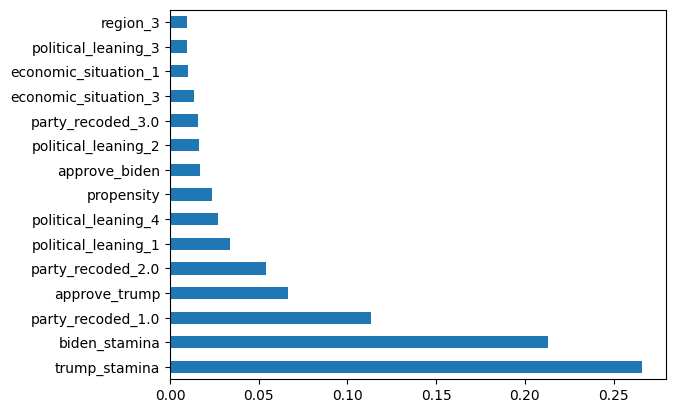

In [734]:
rf = RandomForestClassifier().fit(X_train, y_train)
y_preds_rf = rf.predict(X_test)
print(f1_score(y_test, y_preds_rf, average='weighted'))
print(classification_report(y_test, y_preds_rf))
features=X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# plt.figure(1)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [735]:
new_model.fit(X_train, y_train)
y_preds = new_model.predict(X_test)
print(f1_score(y_test, y_preds, average='weighted'))
print(classification_report(y_test, y_preds))

0.9495170147406978
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       160
           1       0.96      0.92      0.94       118

    accuracy                           0.95       278
   macro avg       0.95      0.95      0.95       278
weighted avg       0.95      0.95      0.95       278



In [736]:
y_test.to_numpy()

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

In [737]:
y_preds

array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [738]:
# map preds back up to the original dataframe
nat_2020_clean_copy =nat_2020_clean2.copy()

In [739]:
X_test_copy = X_test.copy()
X_test_copy.columns

Index(['approve_trump', 'approve_biden', 'trump_stamina', 'biden_stamina',
       'optimistic', 'male', 'propensity', 'registered_vote_True', 'region_1',
       'region_2', 'region_3', 'region_4', 'economic_situation_1',
       'economic_situation_2', 'economic_situation_3', 'economic_situation_9',
       'likely_to_vote_1.0', 'likely_to_vote_2.0', 'likely_to_vote_3.0',
       'likely_to_vote_4.0', 'education_recoded_1', 'education_recoded_3',
       'elec_enthusiasm_1.0', 'elec_enthusiasm_2.0', 'elec_enthusiasm_3.0',
       'elec_enthusiasm_9.0', 'political_leaning_1', 'political_leaning_2',
       'political_leaning_3', 'political_leaning_4', 'race_recoded_1',
       'race_recoded_2', 'race_recoded_3', 'race_recoded_4', 'race_recoded_9',
       'party_recoded_1.0', 'party_recoded_2.0', 'party_recoded_3.0',
       'age_recoded_1', 'age_recoded_2', 'age_recoded_3'],
      dtype='object')

In [740]:

X_test_copy['predicted_vote'] = y_preds
X_test_copy['actual_vote'] = y_test
# X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','focused_imp_issues','male', 'propensity',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
#        'race_recoded_9', 'party_recoded_1.0',
#        'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3',
#        'vote_choice_recoded', 'actual_vote']]
X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male', 'propensity',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
       'race_recoded_9', 'party_recoded_1.0',
       'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote']]

In [741]:
# turn the dummies back into regular columns
X_test_copy_no_dummies = X_test_copy_filtered.copy()


In [742]:
X_test_copy_filtered

,approve_trump,approve_biden,optimistic,male,propensity,race_recoded_1,race_recoded_2,race_recoded_3,race_recoded_4,race_recoded_9,party_recoded_1.0,party_recoded_2.0,age_recoded_1,age_recoded_2,age_recoded_3,predicted_vote,actual_vote
401,False,False,True,True,0.166517,False,True,False,False,False,True,False,False,True,False,1,1
305,False,False,False,True,0.530773,True,False,False,False,False,False,True,True,False,False,0,0
328,False,False,False,True,0.670994,True,False,False,False,False,False,True,False,True,False,0,0
28,False,False,False,False,0.684399,True,False,False,False,False,True,False,False,True,False,1,1
162,False,False,False,False,0.662109,True,False,False,False,False,False,True,False,False,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,False,False,False,False,0.670994,True,False,False,False,False,False,False,False,True,False,0,0
681,False,False,False,False,0.670994,True,False,False,False,False,False,True,False,True,False,0,0
47,False,False,False,True,0.662109,True,False,False,False,False,True,False,False,False,True,0,0
584,False,True,True,False,0.670994,True,False,False,False,False,False,False,False,True,False,0,0


In [743]:
# filter the nat_2020_june with the indexes in X_test_copy_filtered

filtered_nat_2020_june = nat_2020_june.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state', 'vote_choice_recoded'])
filtered_nat_2020_june['predicted_vote'] = X_test_copy_filtered['predicted_vote']
filtered_nat_2020_june['actual_vote'] = X_test_copy_filtered['actual_vote']
filtered_nat_2020_june

,economic_situation,registered_vote,likely_to_vote,approve_trump,approve_biden,trump_stamina,biden_stamina,optimistic,elec_enthusiasm,political_leaning,FINALWGT,party_recoded,age_recoded,race_recoded,male,education_recoded,region,propensity,predicted_vote,actual_vote
401,3,True,1.0,False,False,True,False,True,1.0,3,0.760208,1.0,2,2,True,3,3,0.166517,1,1
305,2,True,1.0,False,False,False,True,False,1.0,4,1.154971,2.0,1,1,True,1,3,0.530773,0,0
328,2,True,1.0,False,False,False,True,False,3.0,3,0.520223,2.0,2,1,True,3,3,0.670994,0,0
28,2,True,2.0,False,False,False,False,False,3.0,2,1.215067,1.0,2,1,False,1,1,0.684399,1,1
162,1,True,1.0,False,False,False,True,False,1.0,1,0.618027,2.0,3,1,False,3,4,0.662109,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,2,True,2.0,False,False,False,True,False,3.0,3,0.805402,3.0,2,1,False,3,4,0.670994,0,0
681,2,True,1.0,False,False,False,True,False,3.0,3,0.578803,2.0,2,1,False,3,3,0.670994,0,0
47,2,True,3.0,False,False,False,True,False,2.0,2,0.652403,1.0,3,1,True,3,3,0.662109,0,0
584,2,True,1.0,False,True,False,True,True,1.0,3,0.628742,3.0,2,1,False,3,4,0.670994,0,0


In [750]:
june_final = filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_11574/197698379.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  june_final = filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_11574/197698379.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_nat_2020_june.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)


predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   2   1
                               3                   5   5
                         True  1                   1   4
                               3                  12   5
            2            False 1                   1   0
                               3                   1   0
                         True  1                   1   1
                               3                   2   0
            3            False 1                   0   0
                               3                   1   0
                         True  1                   0   0
                               3                   0   0
            4            False 1                   0   0
                               3                   2   1
                         True  1                   1   0
                               3                   4   2
            9            False 1                   0   0
                               3                   0   0
                         True  1                   0   1
                               3                   0   0
2           1            False 1                   4   3
                               3                  22  12
                         True  1                   2   6
                               3                  10  21
            2            False 1                   0   0
                               3                   8   0
                         True  1                   1   0
                               3                   7   2
            3            False 1                   0   0
                               3                   0   0
                         True  1                   0   0
                               3                   1   1
            4            False 1                   0   0
                               3                   5   2
                         True  1                   0   1
                               3                   0   3
            9            False 1                   0   0
                               3                   2   0
                         True  1                   0   1
                               3                   1   1
3           1            False 1                   9   5
                               3                  18  17
                         True  1                   4   4
                               3                  18   4
            2            False 1                   1   1
                               3                   8   1
                         True  1                   4   0
                               3                   1   0
            3            False 1                   0   0
                               3                   2   1
                         True  1                   0   0
                               3                   1   2
            4            False 1                   0   1
                               3                   1   1
                         True  1                   0   0
                               3                   0   1
            9            False 1                   0   1
                               3                   1   0
                         True  1                   0   0
                               3                   0   2

In [725]:

filtered_nat_2020 = nat_2020.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'state', 'vote_choice_recoded'])
filtered_nat_2020['predicted_vote'] = X_test_copy_filtered['predicted_vote']
filtered_nat_2020['actual_vote'] = X_test_copy_filtered['actual_vote']
filtered_nat_2020
march_final = filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_11574/4125733370.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  march_final = filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_11574/4125733370.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_nat_2020.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)


predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   2   2
                               3                   9   7
                         True  1                   1   1
                               3                   5   8
            2            False 1                   1   2
                               3                   0   1
                         True  1                   0   1
                               3                   0   2
            3            False 1                   0   0
                               3                   0   0
                         True  1                   0   0
                               3                   0   1
            4            False 1                   1   2
                               3                   0   1
                         True  1                   0   1
                               3                   5   0
            9            False 1                   0   0
                               3                   0   0
                         True  1                   1   0
                               3                   0   0
2           1            False 1                   1   2
                               3                  16  13
                         True  1                   4   3
                               3                   7  15
            2            False 1                   0   0
                               3                   5   1
                         True  1                   0   2
                               3                   3   2
            3            False 1                   0   0
                               3                   1   1
                         True  1                   0   0
                               3                   1   0
            4            False 1                   0   0
                               3                   4   2
                         True  1                   1   1
                               3                   2   3
            9            False 1                   0   0
                               3                   1   0
                         True  1                   1   0
                               3                   0   1
3           1            False 1                   7   8
                               3                  13  10
                         True  1                   1   4
                               3                   7  13
            2            False 1                   1   2
                               3                   1   0
                         True  1                   0   0
                               3                   3   4
            3            False 1                   0   0
                               3                   0   1
                         True  1                   0   0
                               3                   0   1
            4            False 1                   1   0
                               3                   2   3
                         True  1                   0   0
                               3                   0   0
            9            False 1                   0   0
                               3                   1   0
                         True  1                   1   0
                               3                   1   3

In [746]:
# filtered_nat_2020 and filtered_nat_2020_june merge on the same columns
filtered_nat_2020_june.columns
merged_df = pd.merge(march_final, june_final, on=['age_recoded',	'race_recoded',	'male',	'education_recoded'], how='outer')
# add 0_x and 0_y together
merged_df['0'] = merged_df['0_x'] + merged_df['0_y']
# add 1_x and 1_y together
merged_df['1'] = merged_df['1_x'] + merged_df['1_y']
# drop the _x and _y columns
merged_df = merged_df.drop(columns = ['0_x', '0_y', '1_x', '1_y'])
merged_df
# add the propensity vibe column
merged_df['propensity_t_pred'] = merged_df['1'] / (merged_df['0'] + merged_df['1'])
merged_df

predicted_vote                                     0   1  propensity_t_pred
age_recoded race_recoded male  education_recoded                           
1           1            False 1                   4   3           0.428571
                               3                  14  12           0.461538
                         True  1                   2   5           0.714286
                               3                  17  13           0.433333
            2            False 1                   2   2           0.500000
                               3                   1   1           0.500000
                         True  1                   1   2           0.666667
                               3                   2   2           0.500000
            3            False 1                   0   0                NaN
                               3                   1   0           0.000000
                         True  1                   0   0                NaN
                               3                   0   1           1.000000
            4            False 1                   1   2           0.666667
                               3                   2   2           0.500000
                         True  1                   1   1           0.500000
                               3                   9   2           0.181818
            9            False 1                   0   0                NaN
                               3                   0   0                NaN
                         True  1                   1   1           0.500000
                               3                   0   0                NaN
2           1            False 1                   5   5           0.500000
                               3                  38  25           0.396825
                         True  1                   6   9           0.600000
                               3                  17  36           0.679245
            2            False 1                   0   0                NaN
                               3                  13   1           0.071429
                         True  1                   1   2           0.666667
                               3                  10   4           0.285714
            3            False 1                   0   0                NaN
                               3                   1   1           0.500000
                         True  1                   0   0                NaN
                               3                   2   1           0.333333
            4            False 1                   0   0                NaN
                               3                   9   4           0.307692
                         True  1                   1   2           0.666667
                               3                   2   6           0.750000
            9            False 1                   0   0                NaN
                               3                   3   0           0.000000
                         True  1                   1   1           0.500000
                               3                   1   2           0.666667
3           1            False 1                  16  13           0.448276
                               3                  31  27           0.465517
                         True  1                   5   8           0.615385
                               3                  25  17           0.404762
            2            False 1                   2   3           0.600000
                               3                   9   1           0.100000
                         True  1                   4   0           0.000000
                               3                   4   4           0.500000
            3            False 1                   0   0                NaN
                               3                   2   2           0.500000
                         True  1                

In [ ]:
# TODO: make function/pipeline that can take in multiple custom datasets to build bigger propensity changer. Then you could use that to continue to cook with new stuff? do more monmouth? maybe 2 more of those plus whatever else we have?

# TODO: Aggregate the propensities from ML and MRP and see if they're similar ish. Then use that to make a new propensity score.

# TODO: with updated propensity score and Census People data from haley, ("../data/census/cleaned/post_stratification_data.csv") multiply by the amount of people in each category and then see if it's predicting the election right on a high level. See if You can find a way to weight the ML scores down to not make it change much. See if certain groups don't show as much. -> use turnout weights to bonk the numbers down to be more realistic?

# TODO: simulate running the ML a bunch of times to get more predictions? like oversample??? OOOOH SMOte LOL

# TODO: include people we dropped for 3rd party purposes? no validation fs but will bump average numbers based on how model predicts